## Restricted Botlzman Machines (RBM)

In [ ]:
#FIXME: Review the generation process (theoretically) and fix the implementation 

In [ ]:
import os
from typing import List, Dict, Tuple, Literal, Optional, Union, Iterable

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io
from tqdm import tqdm
from numpy._typing import ArrayLike

ArrayLike = Union[List, Tuple, np.ndarray]

In [ ]:
DATA_FOLDER = "../data/"
ALPHA_DIGIT_PATH = os.path.join(DATA_FOLDER, "binaryalphadigs.mat")
MNIST_PATH = os.path.join(DATA_FOLDER, "mnist_all.mat")

if not os.path.exists(ALPHA_DIGIT_PATH):
    raise FileNotFoundError(f"The file {ALPHA_DIGIT_PATH} does not exist.")

### 3.1 Implementing a RBM and testing on Binary AlphaDigits

In [ ]:
def _load_data(file_path: str) -> Dict[str, np.ndarray]:
    """
    Load Binary AlphaDigits data from a .mat file.

    Parameters:
    - file_path (str): Path to the .mat file containing the data.

    Returns:
    - data (dict): Loaded data dictionary.
    """
    if file_path is None:
        raise ValueError("File path must be provided.")

    return scipy.io.loadmat(file_path)


data = _load_data(ALPHA_DIGIT_PATH)
class_labels = data["classlabels"].flatten() 
class_count = data["classcounts"].flatten()
df = pd.DataFrame(
    {
        "Class Labels": class_labels,
        "Class Count": class_count
    }
)
df["Class Labels"] = df["Class Labels"].apply(lambda x: x[0])
df["Class Count"] = df["Class Count"].apply(lambda x: x[0][0])
df

In [ ]:
def _load_data(file_path: str, which: Literal["alphadigit", "mnist"]="alphadigit") -> Dict[str, np.ndarray]:
    """
    Load Binary AlphaDigits data from a .mat file.

    Parameters:
    - file_path (str): Path to the .mat file containing the data.
    - which (Literal["alphadigit", "mnist"], optional): Specifies 
        which data to load. The default value is "alphadigit".

    Returns:
    - data (dict): A dictionary containing the loaded data.

    Raises:
    - ValueError: If the file_path parameter is None.
    - ValueError: If the which parameter is not "alphadigit".

    Example Usage:
    ```python
    data = _load_data("data.mat", "alphadigit")
    ```
    """
    if file_path is None:
        raise ValueError("File path must be provided.")
    
    if which == "alphadigit":
        return scipy.io.loadmat(file_path)["dat"]
    
    raise ValueError("MNIST NOT YET AVAILABLE.")

alphadigit_data = _load_data(ALPHA_DIGIT_PATH) 
print(alphadigit_data.shape)
print(alphadigit_data[0][0].shape)

In [ ]:
def _map_characters_to_indices(characters: Union[str, int, List[Union[str, int]]]) -> List[int]:
    """
    Map alphanumeric character to its corresponding index.

    Parameters:
    - character (str, int, list of str or int): Alphanumeric character or its index.

    Returns:
    - char_index (int): Corresponding index for the character.
    """
    if isinstance(characters, list):
        return [_map_characters_to_indices(char) for char in characters]
    if isinstance(characters, int) and 0 <= characters <= 35:
        return [characters]
    if (isinstance(characters, str) and characters.isdigit()
          and 0 <= int(characters) <= 9):
        return [int(characters)]
    if (isinstance(characters, str) and characters.isalpha()
          and 'A' <= characters.upper() <= 'Z'):
        return [ord(characters.upper()) - ord('A') + 10]
    
    raise ValueError(
        "Invalid character input. It should be an alphanumeric" 
        "character '[0-9|A-Z]' or its index representing '[0-35]'."
    )

for char in [0, 10, "A", [1, "C"], 36]:
    try:
        map = _map_characters_to_indices(char)
        print(f"{char} > map to > {map}")
    except:
        print(f"{char} > no mapping available, out of range")

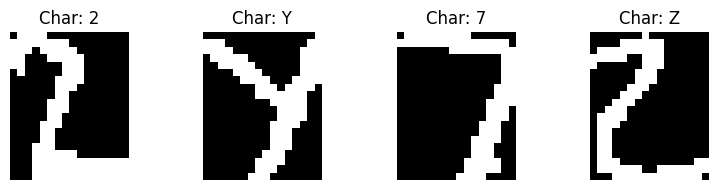

In [72]:
def read_alpha_digit(characters: Optional[Union[str, int, List[Union[str, int]]]] = None,
                     file_path: Optional[str] = ALPHA_DIGIT_PATH,
                     data: Optional[Dict[str, np.ndarray]] = None,
                     use_data: bool = False,
                     ) -> np.ndarray:
    """
    Reads binary AlphaDigits data from a .mat file or uses already loaded data. 
    It extracts the data for a specified alphanumeric character or its index, and 
    flattens the images into one-dimensional vectors.

    Parameters:
    - characters (Union[str, int, List[Union[str, int]]], optional): Alphanumeric character 
        or its index whose data needs to be extracted. It can be a single character or 
        a list of characters. Default is None.
    - file_path (str, optional): Path to the .mat file containing the data. 
        Default is None.
    - data (dict, optional): Already loaded data dictionary. 
        Default is None.
    - use_data (bool): Flag to indicate whether to use already loaded data.
        Default is False.

    Returns:
    - flattened_images (numpy.ndarray): Flattened images for the specified character(s).
    """
    if not use_data:
        data = _load_data(file_path, which="alphadigit")

    char_indices = _map_characters_to_indices(characters)

    # Select the rows corresponding to the characters indices.
    char_data: np.ndarray = data[char_indices]
    
    # Flatten each image into a one-dimensional vector.
    flattened_images = np.array([image.flatten() for image in char_data.flatten()])
    return flattened_images

def plot_characters(chars, data):
    num_chars = len(chars)
    num_images_per_char = data.shape[0] // num_chars
    fig, ax = plt.subplots(1, num_chars, figsize=(num_chars * 2, 2))

    for i, char in enumerate(chars):
        # Find the index of the first image corresponding to the current char
        start_index = i * num_images_per_char
        image = data[start_index].reshape(20, 16)
        ax[i].imshow(image, cmap='gray')
        ax[i].set_title(f'Char: {char}')
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example
chars = [2, "Y", 7, "Z"]
data = read_alpha_digit(chars, data=alphadigit_data, use_data=True)
plot_characters(chars, data)

In [ ]:
print("data shape:", data.shape)

In [ ]:
class RBM:
    def __init__(self, n_visible: int, n_hidden: int=100, random_state=None) -> None:
        """
        Initialize the Restricted Boltzmann Machine.

        Parameters:
        - n_visible (int): Number of visible units.
        - n_hidden (int): Number of hidden units. Default 100.
        - random_state: Random seed for reproducibility.
        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        
        self.a = np.zeros((1, n_visible)) # visible_bias
        self.b = np.zeros((1, n_hidden)) # hidden_bias
        self.rng = np.random.default_rng(random_state)
        self.W = 1e-4 * self.rng.standard_normal(size=(n_visible, n_hidden)) # weights

    def __repr__(self) -> str:
        return f"RBM(n_visible={self.n_visible}, n_hidden={self.n_hidden})"

    def _sigmoid(self, x: np.ndarray) -> np.ndarray:
        """
        Sigmoid activation function.

        Parameters:
        - x (numpy.ndarray): Input array.

        Returns:
        - numpy.ndarray: Result of applying the sigmoid function to the input.
        """
        return 1 / (1 + np.exp(-x))
    
    def _reconstruction_error(self, input: np.ndarray, image: np.ndarray) -> float:
        """
        Compute reconstruction error.

        Parameters:
        - input (numpy.ndarray): Original input data.
        - image (numpy.ndarray): Reconstructed image.

        Returns:
        - float: Reconstruction error.
        """
        return np.round(np.power(image - input, 2).mean(), 5)

    def input_output(self, data: np.ndarray) -> np.ndarray:
        """
        Compute hidden units given visible units.

        Parameters:
        - data (numpy.ndarray): Input data, shape (n_samples, n_visible).

        Returns:
        - numpy.ndarray: Hidden unit activations, shape (n_samples, n_hidden).
        """
        return self._sigmoid(data @ self.W + self.b)

    def output_input(self, data_h: np.ndarray) -> np.ndarray:
        """
        Compute visible units given hidden units.

        Parameters:
        - data_h (numpy.ndarray): Hidden unit activations, shape (n_samples, n_hidden).

        Returns:
        - numpy.ndarray: Reconstructed visible units, shape (n_samples, n_visible).
        """
        return self._sigmoid(data_h @ self.W.T + self.a)
    
    def calcul_softmax(self, data: np.ndarray) -> np.ndarray:
        """
        Calculate softmax probabilities for the output units.

        Parameters:
        - input_data (numpy.ndarray): Input data, shape (n_samples, n_visible).

        Returns:
        - numpy.ndarray: Softmax probabilities, shape (n_samples, n_hidden).
        """
        # Compute activations for the hidden layer
        hidden_activations = self.input_output(data)
        
        # Compute softmax probabilities for the output layer
        exp_hidden_activations = np.exp(hidden_activations)
        softmax_probs = exp_hidden_activations / np.sum(exp_hidden_activations, axis=1, keepdims=True)
        
        return softmax_probs

    def update(
            self, 
            batch: np.ndarray,
            learning_rate: float=0.1,
            batch_size: Optional[int]=None,
            return_output: bool=False
        ):
        """_summary_

        Args:
            batch (np.ndarray): _description_
            learning_rate (float, optional): _description_. Defaults to 0.1.
            batch_size (Optional[int], optional): _description_. Defaults to None.
            return_output (bool, optional): _description_. Defaults to False.
        """
        if not batch_size:
            batch_size = batch.shape[0]
        pos_h_probs = self.input_output(batch)
        pos_v_probs = self.output_input(pos_h_probs)
        neg_h_probs = self.input_output(pos_v_probs)
        
        # Update weights and biases
        self.W += learning_rate * (batch.T @ pos_h_probs - pos_v_probs.T @ neg_h_probs) / batch_size
        self.b += learning_rate * (pos_h_probs - neg_h_probs).mean(axis=0)
        self.a += learning_rate * (batch - pos_v_probs).mean(axis=0)

        if return_output:
            return self, pos_v_probs
        
        return self 

    def train(self, 
              data: np.ndarray,
              learning_rate: float=0.1,
              n_epochs: int=10,
              batch_size: int=10,
              print_each=10
        ) -> 'RBM':
        """
        Train the RBM using Contrastive Divergence.

        Parameters:
        - data (numpy.ndarray): Input data, shape (n_samples, n_visible).
        - learning_rate (float): Learning rate for gradient descent. Default is 0.1.
        - n_epochs (int): Number of training epochs. Default is 10.
        - batch_size (int): Size of mini-batches. Default is 10.

        Returns:
        - RBM: Trained RBM instance.
        """
        n_samples = data.shape[0]
        for epoch in range(n_epochs):
            self.rng.shuffle(data)
            for i in tqdm(range(0, n_samples, batch_size), desc=f"Epoch {epoch}"):
                batch = data[i:i+batch_size]
                _, pos_v_probs = self.update(
                    batch=batch,
                    learning_rate=learning_rate,
                    batch_size=batch_size,
                    return_output=True
                )
                
            if epoch % print_each == 0:
                tqdm.write(
                    f"Reconstruction error: {self._reconstruction_error(batch, pos_v_probs)}.")

        return self

    def generate_image(self, n_samples: int=1, n_gibbs_steps: int=1) -> np.ndarray:
        """
        Generate samples from the RBM using Gibbs sampling.

        Parameters:
        - n_samples (int): Number of samples to generate. Default is 10.
        - n_gibbs_steps (int): Number of Gibbs sampling steps. Default is 1.

        Returns:
        - numpy.ndarray: Generated samples, shape (n_samples, n_visible).
        """
        samples = np.zeros((n_samples, self.n_visible))
        
        # Matrix of initlization value of Gibbs samples for each sample. 
        V = self.rng.binomial(1, self.rng.random(), size=n_samples*self.n_visible).reshape((n_samples, self.n_visible))
        for i in range(n_samples):
            for _ in range(n_gibbs_steps):
                h_probs = self._sigmoid(V[i] @ self.W + self.b) # vector
                h = self.rng.binomial(1, h_probs)
                v_probs = self._sigmoid(h @ self.W.T + self.a)
                v = self.rng.binomial(1, v_probs)
            samples[i] = v
        return samples

In [ ]:
# Load the alpha_digit data
data = read_alpha_digit(file_path=ALPHA_DIGIT_PATH, characters=['Z'])

In [ ]:
# Parameters
n_visible = data.shape[1]  # Number of visible units (size of each image)
n_hidden = 200  # Number of hidden units (hyperparameter)

# Initialize RBM
rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, random_state=42)
print(rbm)

# Train RBM
rbm.train(data, learning_rate=0.1, n_epochs=500, batch_size=10)

In [ ]:
np.testing.assert_allclose(rbm.calcul_softmax(data).sum(1), 1)

In [ ]:
# Generate samples
generated_samples = rbm.generate_image(n_samples=10, n_gibbs_steps=1)

# Plot original and generated samples
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(data[i].reshape(20, 16), cmap='gray')
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(2, 10, i + 11)
    plt.imshow(generated_samples[i].reshape(20, 16), cmap='gray')
    plt.title('Generated')
    plt.axis('off')

plt.show()

In [ ]:
print(rbm)

### 3.2 Implementing a Deep Belief Network (DBN) and test on Binary AlphaDigits

In [ ]:
class DBN:
    def __init__(self, n_visible: int, hidden_layer_sizes: list[int], random_state=None):
        """
        Initialize the Deep Belief Network.

        Parameters:
        - n_visible (int): Number of visible units.
        - hidden_layer_sizes (list[int]): List of sizes for each hidden layer.
        - random_state: Random seed for reproducibility.
        """
        self.n_visible = n_visible
        self.hidden_layer_sizes = hidden_layer_sizes
        self.rbms: List[RBM] = []
        self.rng = np.random.default_rng(random_state)

        # Initialize the first RBM
        first_rbm = RBM(
            n_visible=n_visible,
            n_hidden=hidden_layer_sizes[0],
            random_state=random_state,
        )
        self.rbms.append(first_rbm)

        # Initialize RBMs for subsequent hidden layers
        for i, size in enumerate(hidden_layer_sizes[1:], start=1):
            rbm = RBM(
                n_visible=hidden_layer_sizes[i - 1],
                n_hidden=size,
                random_state=random_state,
            )
            self.rbms.append(rbm)


    def __getitem__(self, key):
        return self.rbms[key]
    

    def __repr__(self):
        """
        Return a string representation of the DBN object.
        """
        rbm_reprs = [f"{'':4}{repr(rbm)}" for rbm in self.rbms]
        join_rbm_reprs = ',\n'.join(rbm_reprs)
        return f"DBN([\n{join_rbm_reprs}\n])"


    def train(self,
        data: np.ndarray,
        learning_rate: float=0.1,
        n_epochs: int=10,
        batch_size: int=10,
        print_each: int=10,
    ) -> "DBN":
        """
        Train the DBN using Greedy layer-wise procedure.

        Parameters:
        - data (numpy.ndarray): Input data, shape (n_samples, n_visible).
        - learning_rate (float): Learning rate for gradient descent. Default is 0.1.
        - n_epochs (int): Number of training epochs. Default is 10.
        - batch_size (int): Size of mini-batches. Default is 10.
        - print_each: Print reconstruction error each `print_each` epochs.
        - verbose

        Returns:
        - DBN: Trained DBN instance.
        """
        input_data = data
        for rbm in self.rbms:
            rbm.train(
                input_data,
                learning_rate=learning_rate,
                n_epochs=n_epochs,
                batch_size=batch_size,
                print_each=print_each,
            )
            # Update input data for the next RBM
            input_data = rbm.input_output(input_data)

        return self

    def generate_image(self, n_samples: int=1, n_gibbs_steps: int=1) -> np.ndarray:
        """
        Generate samples from the DBN using Gibbs sampling.

        Parameters:
        - n_samples (int): Number of samples to generate. Default is 1.
        - n_gibbs_steps (int): Number of Gibbs sampling steps. Default is 100.

        Returns:
        - numpy.ndarray: Generated samples, shape (n_samples, n_visible).
        """
        # samples = np.zeros((n_samples, self.n_visible))

        # Generate samples using the first RBM in the DBN
        samples = self.rbms[-1].generate_image(n_samples, n_gibbs_steps)
        for rbm in reversed(self.rbms[:-1]):
            # Sample from the conditional probability of layer l-1 given layer l: p(h_{s-1}|h_{s}).
            h_probs = rbm.output_input(samples)
            h = self.rng.binomial(1, p=h_probs) 
            samples = h
        return samples

In [ ]:
# from principal_dbn_alpha import DBN

In [ ]:
n_visible=data.shape[1]
hidden_layer_sizes = [100, 50, 25]

dbn = DBN(n_visible=n_visible, hidden_layer_sizes=hidden_layer_sizes, random_state=42)
dbn.train(data, learning_rate=0.1, n_epochs=10, batch_size=10)

In [ ]:
# Check if the RBM are accessibles via a slicing 
print(dbn[1:3])

In [ ]:
# # Generate images
generated_images = dbn.generate_image(n_samples=5, n_gibbs_steps=1)

# Display generated images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 4))
for i in range(5):
    axes[i].imshow(generated_images[i].reshape(20, 16), cmap='gray')
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class DNN(DBN):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_layer_sizes: List[int],
        random_state=None
    ):
        """
        Initialize the Deep Neural Network (DNN).

        Parameters:
        - input_dim (int): Dimension of the input.
        - output_dim (int): Dimension of the output.
        - hidden_layer_sizes (List[int]): List of sizes for each hidden layer.
        - random_state: Random seed for reproducibility.
        """
        super().__init__(
            n_visible=input_dim,
            hidden_layer_sizes=hidden_layer_sizes,
            random_state=random_state
        )
        #--> self.rbms contains only the pre-trainable RBMs 
        self.clf = RBM(self.rbms[-1].n_hidden, output_dim)
        self.network = self.rbms + [self.clf]  # DNN = [DBN + Classifier] ~ [RBM_0,...,RBM_N, RBM_Clf]

    def __getitem__(self, key):
        return self.network[key]
    
    def __repr__(self):
        join_repr = "\n".join([f"{'':4}{repr(rbm)}," for rbm in self.network])
        return f"DNN([\n{join_repr} <HEAD CLF>\n])"
    
    
    def pretrain(self, n_epochs: int, learning_rate: float, batch_size: int, data: np.ndarray) -> "DNN":
        """
        Pretrain the hidden layers of the DNN using the DBN training method.

        Parameters:
        - n_epochs (int): Number of training epochs.
        - learning_rate (float): Learning rate for gradient descent.
        - batch_size (int): Size of mini-batches.
        - data (numpy.ndarray): Input data, shape (n_samples, n_visible).

        Returns:
        - DNN: Pretrained DNN instance.
        """
        # NOTE: Use the inherited `train` method to perform pre-training since `self.rbms`
        # only contains the pre-trainable RBMs.
        return self.train(data, n_epochs=n_epochs, learning_rate=learning_rate, batch_size=batch_size)
    
    def input_output(self, input_data: np.ndarray) -> Tuple[List[np.ndarray], np.ndarray]:
        """
        Get the outputs on each layer of the DNN and the softmax probabilities on the output layer.

        Parameters:
        - input_data (numpy.ndarray): Input data, shape (n_samples, n_visible).

        Returns:
        - Tuple[List[np.ndarray], np.ndarray]: Outputs on each layer & softmax probabilities.
        """
        layer_outputs = []
        
        # Input layer output
        layer_outputs.append(input_data)
        
        # Hidden layers output
        for rbm in self.rbms:
            layer_outputs.append(rbm.input_output(layer_outputs[-1]))
        
        # Softmax probabilities on the output layer
        output_probs = self.network[-1].calcul_softmax(layer_outputs[-1])
        
        return layer_outputs, output_probs
    

    def _cross_entropy(batch_labels: np.ndarray, output_probs: np.ndarray, eps: float = 1e-15) -> float:
        """
        Calculate the cross entropy between the batch labels and output probabilities.

        Parameters:
        - batch_labels (numpy.ndarray): True labels for the batch, shape (batch_size, n_classes).
        - output_probs (numpy.ndarray): Predicted probabilities for the batch, shape (batch_size, n_classes).
        - eps (float): Small value to avoid numerical instability in logarithm calculation. Default is 1e-15.

        Returns:
        - float: Cross entropy value.
        """
        return -np.mean(np.sum(batch_labels * np.log(output_probs + eps), axis=1))


    def backpropagation(
            self,
            input_data: np.ndarray,
            labels: np.ndarray,
            n_epochs: int,
            learning_rate: float,
            batch_size: int,
            eps: float = 1e-15
        ) -> "DNN":
        """
        Estimate the weights/biases of the network using backpropagation algorithm.

        Parameters:
        - input_data (numpy.ndarray): Input data, shape (n_samples, n_visible).
        - labels (numpy.ndarray): Labels for the input data, shape (n_samples, n_classes).
        - n_epochs (int): Number of training epochs.
        - learning_rate (float): Learning rate for gradient descent.
        - batch_size (int): Size of mini-batches.
        - eps (float): Small value to avoid numerical instability in logarithm calculation. Default is 1e-15.

        Returns:
        - DNN: Updated DNN instance.
        """
        n_samples = input_data.shape[0]
        
        for epoch in tqdm(range(n_epochs), desc="Training", unit="epoch"):
            for batch_start in range(0, n_samples, batch_size):
                batch_end = min(batch_start + batch_size, n_samples)
                batch_input = input_data[batch_start:batch_end]
                batch_labels = labels[batch_start:batch_end]

                # Forward pass
                layer_outputs, output_probs = self.input_output(batch_input)

                # Backward pass (update weights and biases)
                self.network[-1].update(batch_labels, layer_outputs[-1], learning_rate)
                for i in range(len(self.network) - 2, -1, -1):
                    self.network[i].update(layer_outputs[i], layer_outputs[i + 1], self.network[i + 1].weights, learning_rate)

            # Calculate cross entropy after each epoch
            loss = self._cross_entropy(batch_labels, output_probs, eps)
            tqdm.write(f"Epoch {epoch + 1}/{n_epochs}, Cross Entropy: {loss}")

        return self


In [ ]:
n_visible=data.shape[1]
hidden_layer_sizes = [100, 50, 25]
output_dim = 20

dnn = DNN(input_dim=n_visible, hidden_layer_sizes=hidden_layer_sizes, output_dim=output_dim, random_state=42)
# keep last RBM's weights for further test.
weights = dnn[-1].W 

dnn.train(data, learning_rate=0.1, n_epochs=10, batch_size=10)

# Check that the last RBM has not been trained.
np.testing.assert_equal (dnn[-1].a, 0) # visible bias
np.testing.assert_equal (dnn[-1].b, 0) # hidden bias
np.testing.assert_equal (dnn[-1].W, weights) # weights

In [ ]:
layer_outputs, softmax_output = dnn.input_output(data)
n_layers_net = len(layer_outputs) + 1
print("No. network output =", n_layers_net)

print(f"Input data (0): {layer_outputs[0].shape}")
for idx, layer_output in enumerate(layer_outputs[1:]):
    print(f"Hidden layer input ({idx+1}): {layer_output.shape}")

print(f"Softmax output ({n_layers_net - 1}):", softmax_output.shape)

# Analysis on ALPHA DIGITS  

In [ ]:
def generate_symmetric_configurations(min_layers, max_layers, min_neurons, max_neurons, step_neurons):
    """
    Générer des configurations symétriques pour les couches cachées du DBN.

    Args:
    min_layers (int): Nombre minimum de couches cachées.
    max_layers (int): Nombre maximum de couches cachées.
    min_neurons (int): Nombre minimum de neurones par couche.
    max_neurons (int): Nombre maximum de neurones par couche.
    step_neurons (int): Pas d'augmentation du nombre de neurones.

    Returns:
    List[List[int]]: Liste des configurations symétriques des couches cachées.
    """
    configurations = []
    for num_layers in range(min_layers, max_layers + 1):
        for num_neurons in range(min_neurons, max_neurons + 1, step_neurons):
            half = num_layers // 2
            config = [num_neurons] * half + [num_neurons] * (num_layers - half)
            configurations.append(config)
    return configurations

## I- Effect of Layers and units

## 1.RBM launch function

In [ ]:
def run_rbm_experiment(hidden_units_sizes, n_epochs=100, character_sets=[['A', 'B'], ['1', '2', '3', '4'], ['A', 'B', '1', '2']]):
    # Déterminer le nombre unique d'unités
    unique_units = sorted(hidden_units_sizes)

    # Préparer une grille de subplots
    fig, axes = plt.subplots(len(character_sets), len(unique_units), figsize=(len(unique_units) * 3, len(character_sets) * 3), squeeze=False)

    for row_idx, characters in enumerate(character_sets):
        data = read_alpha_digit(characters, file_path=ALPHA_DIGIT_PATH)

        for col_idx, num_units in enumerate(unique_units):
            print(f"\nTraining RBM with {num_units} hidden units on characters {characters}")
            rbm = RBM(n_visible=data.shape[1], n_hidden=num_units, random_state=42)
            rbm.train(data, learning_rate=0.1, n_epochs=n_epochs, batch_size=15, print_each=5000)

            # Génération et affichage d'une image
            generated_image = rbm.generate_image(n_samples=1)

            # Enregistrer l'image
            save_path = f"../resultat/rbm/{num_units}_Units_{len(characters)}_Chars.npy"
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            np.save(save_path, generated_image)

            ax = axes[row_idx, col_idx]
            ax.imshow(generated_image[0].reshape(20, 16), cmap='plasma')
            ax.set_title(f"Units: {num_units}, N_Chars: {len(characters)}")
            ax.axis('off')

    plt.tight_layout()
    # Enregistrement de l'image générée
    directory_image = "../resultat/images/rbm"
    os.makedirs(directory_image, exist_ok=True)
    plt.savefig(f"{directory_image}/rbm_{len(characters)}_chars_Units_{num_units}_Layers_{character_sets}.png")
    plt.tight_layout()
    plt.show()


In [ ]:
hidden_units_sizes = [100, 200, 300, 400, 500, 600, 700]
run_rbm_experiment(hidden_units_sizes, n_epochs=1000, character_sets=['Y'])


In [ ]:
run_rbm_experiment(hidden_units_sizes, n_epochs=1000, character_sets=['Y'])


## 2. DBM launch function

In [ ]:
import matplotlib.pyplot as plt

def run_experiment(hidden_layers_sizes, n_epochs=100, characters=['A', 'B', '1', '2']):
    data = read_alpha_digit(characters, file_path=ALPHA_DIGIT_PATH)

    # Déterminer le nombre maximum de couches et le nombre unique d'unités
    max_layers = max(len(sizes) for sizes in hidden_layers_sizes)
    unique_units = sorted({sizes[0] for sizes in hidden_layers_sizes})

    # Préparer une grille de subplots
    fig, axes = plt.subplots(len(unique_units), max_layers, figsize=(max_layers * 3, len(unique_units) * 3), squeeze=False)

    # Initialiser tous les axes comme invisibles; ils seront activés lorsqu'utilisés
    for ax_row in axes:
        for ax in ax_row:
            ax.set_visible(False)

    for layer_sizes in hidden_layers_sizes:
        print(f"\nTraining DBN with hidden layers: {layer_sizes}")
        dbn = DBN(n_visible=data.shape[1], hidden_layer_sizes=layer_sizes, random_state=42)
        dbn.train(data, learning_rate=0.1, n_epochs=n_epochs, batch_size=16, print_each=1000000)

        # Génération et affichage d'une image
        generated_image = dbn.generate_image(n_samples=1)
        unit_idx = unique_units.index(layer_sizes[0])
        layer_idx = len(layer_sizes) - 2  # Index 0 pour 2 couches, index 1 pour 3 couches, etc.

        ax = axes[unit_idx][layer_idx]
        ax.set_visible(True)
        ax.imshow(generated_image[0].reshape(20, 16), cmap='plasma')
        ax.set_title(f"N_Layers: {len(layer_sizes)}, N_Units: {layer_sizes[0]}")
        ax.axis('off')

        # Enregistrement de l'image générée
        directory = f"../resultat/dbn/{layer_sizes[0]}_Units_{len(layer_sizes)}_Layers"
        os.makedirs(directory, exist_ok=True)
        np.save(f"{directory}/Units_{layer_sizes[0]}_Chars_{''.join(characters)}.npy", generated_image[0])

    #save figure
    plt.tight_layout()
    directory_image = "../resultat/images/dbn"
    os.makedirs(directory_image, exist_ok=True)
    plt.savefig(f"{directory_image}/dbn_{len(characters)}_chars_{layer_sizes[0]}_Units_{len(layer_sizes)}_Layers.png")
    plt.tight_layout()
    plt.show()



In [ ]:
# Exemple d'utilisation avec des configurations générées
configurations = generate_symmetric_configurations(min_layers = 2, max_layers = 5, min_neurons = 100, max_neurons = 700, step_neurons = 100)
run_experiment(configurations, n_epochs=1000, characters=['Y'])

## I- Effect of the number of characters on reconstruction

### 1. RBM

In [ ]:
# configuration = 2 layer with 200 units each
configurations_fixe = generate_symmetric_configurations(min_layers = 2, max_layers = 2, min_neurons = 200, max_neurons = 200, step_neurons = 100)

run_experiment(configurations_fixe, n_epochs=2, characters = ['Y'])
run_experiment(configurations_fixe, n_epochs=2, characters = ['E', 'Y'])
run_experiment(configurations_fixe, n_epochs=2, characters = ['E', 'Y', '2'])
run_experiment(configurations_fixe, n_epochs=2, characters = ['E', 'Y', 'G', '2'])
run_experiment(configurations_fixe, n_epochs=2, characters=['E', 'Y', 'G', '2', '7'])

In [ ]:
# Exemple d'utilisation
hidden_units_sizes = [100, 200, 300, 400, 500, 600, 700]
run_rbm_experiment(hidden_units_sizes, n_epochs=2, character_sets=[['A', 'B'], ['A', 'B', 'C'], ['A', 'B', 'C', 'D']])


### 2. DBM

In [74]:
import matplotlib.pyplot as plt

def run_experiment(hidden_layers_sizes, n_epochs=100, characters=['A', 'B', '1', '2']):
    data = read_alpha_digit(characters, file_path=ALPHA_DIGIT_PATH)

    # Déterminer le nombre maximum de couches et le nombre unique d'unités
    max_layers = max(len(sizes) for sizes in hidden_layers_sizes)
    unique_units = sorted({sizes[0] for sizes in hidden_layers_sizes})

    # Préparer une grille de subplots
    fig, axes = plt.subplots(len(unique_units), max_layers, figsize=(max_layers * 3, len(unique_units) * 3), squeeze=False)

    # Initialiser tous les axes comme invisibles; ils seront activés lorsqu'utilisés
    for ax_row in axes:
        for ax in ax_row:
            ax.set_visible(False)

    for layer_sizes in hidden_layers_sizes:
        print(f"\nTraining DBN with hidden layers: {layer_sizes}")
        dbn = DBN(n_visible=data.shape[1], hidden_layer_sizes=layer_sizes, random_state=42)
        dbn.train(data, learning_rate=0.1, n_epochs=n_epochs, batch_size=16, print_each=1000000)

        # Génération et affichage d'une image
        generated_image = dbn.generate_image(n_samples=1)
        unit_idx = unique_units.index(layer_sizes[0])
        layer_idx = len(layer_sizes) - 2  # Index 0 pour 2 couches, index 1 pour 3 couches, etc.

        ax = axes[unit_idx][layer_idx]
        ax.set_visible(True)
        ax.imshow(generated_image[0].reshape(20, 16), cmap='plasma')
        ax.set_title(f"N_Layers: {len(layer_sizes)}, N_Units: {layer_sizes[0]}, N_Chars: {len(characters)}")
        ax.axis('off')

        # Enregistrement de l'image générée
        directory = f"../resultat/dbn/{layer_sizes[0]}_Units_{len(layer_sizes)}_Layers"
        os.makedirs(directory, exist_ok=True)
        np.save(f"{directory}/Units_{layer_sizes[0]}_Chars_{''.join(characters)}.npy", generated_image[0])

    #save figure
    plt.tight_layout()
    directory_image = "../resultat/images/dbn"
    os.makedirs(directory_image, exist_ok=True)
    plt.savefig(f"{directory_image}/dbn_{len(characters)}_chars_{layer_sizes[0]}_Units_{len(layer_sizes)}_Layers.png")
    plt.tight_layout()
    plt.show()




Training DBN with hidden layers: [400, 400, 400, 400]


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 295.31it/s]


Reconstruction error: 0.20307.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 260.75it/s]


Reconstruction error: 0.19651.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 47.70it/s]


Reconstruction error: 0.17436.


Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 396.61it/s]


Reconstruction error: 0.18903.


Epoch 999: 100%|██████████| 3/3 [00:00<00:00, 415.65it/s]


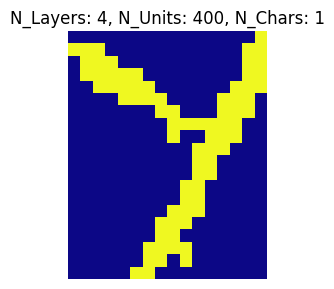

In [76]:
# Exemple d'utilisation avec des configurations générées
configurations = generate_symmetric_configurations(min_layers = 4, max_layers = 4, min_neurons = 400, max_neurons = 400, step_neurons = 100)
run_experiment(configurations, n_epochs=1000, characters=['Y'])



Training DBN with hidden layers: [400, 400, 400, 400]


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 395.25it/s]


Reconstruction error: 0.22324.


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 242.99it/s]


Reconstruction error: 0.17522.


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 202.93it/s]


Reconstruction error: 0.16186.


Epoch 0: 100%|██████████| 5/5 [00:00<00:00, 298.82it/s]


Reconstruction error: 0.12466.


Epoch 999: 100%|██████████| 5/5 [00:00<00:00, 485.91it/s]


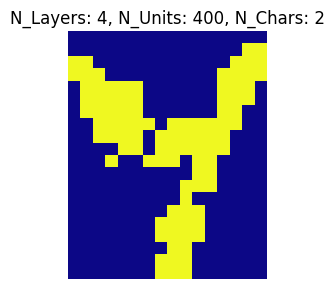

In [77]:
# Exemple d'utilisation avec des configurations générées
configurations = generate_symmetric_configurations(min_layers = 4, max_layers = 4, min_neurons = 400, max_neurons = 400, step_neurons = 100)
run_experiment(configurations, n_epochs=1000, characters=['Y', 'A'])




Training DBN with hidden layers: [400, 400, 400, 400]


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 304.66it/s]


Reconstruction error: 0.234.


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 319.60it/s]


Reconstruction error: 0.15081.


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 250.44it/s]


Reconstruction error: 0.18202.


Epoch 0: 100%|██████████| 8/8 [00:00<00:00, 301.44it/s]


Reconstruction error: 0.14017.


Epoch 999: 100%|██████████| 8/8 [00:00<00:00, 298.77it/s]


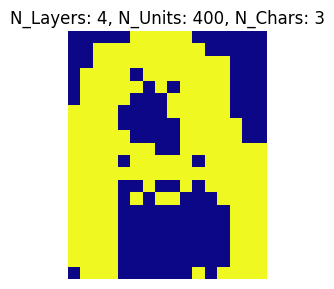

In [78]:
# Exemple d'utilisation avec des configurations générées
configurations = generate_symmetric_configurations(min_layers = 4, max_layers = 4, min_neurons = 400, max_neurons = 400, step_neurons = 100)
run_experiment(configurations, n_epochs=1000, characters=['Y', 'A', 'B'])




Training DBN with hidden layers: [400, 400, 400, 400]


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 304.15it/s]


Reconstruction error: 0.22848.


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 268.29it/s]


Reconstruction error: 0.10906.


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 331.69it/s]


Reconstruction error: 0.13555.


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 267.89it/s]


Reconstruction error: 0.12631.


Epoch 999: 100%|██████████| 10/10 [00:00<00:00, 319.36it/s]


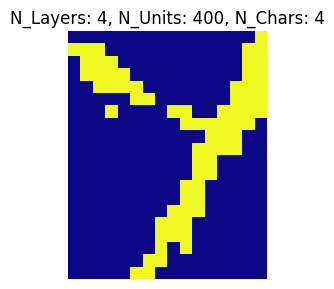

In [79]:
# Exemple d'utilisation avec des configurations générées
configurations = generate_symmetric_configurations(min_layers = 4, max_layers = 4, min_neurons = 400, max_neurons = 400, step_neurons = 100)
run_experiment(configurations, n_epochs=1000, characters=['Y', 'A', 'B', '1'])




Training DBN with hidden layers: [400, 400, 400, 400]


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 324.55it/s]


Reconstruction error: 0.21863.


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 247.45it/s]


Reconstruction error: 0.14901.


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 281.74it/s]


Reconstruction error: 0.14885.


Epoch 0: 100%|██████████| 13/13 [00:00<00:00, 380.57it/s]


Reconstruction error: 0.14724.


Epoch 999: 100%|██████████| 13/13 [00:00<00:00, 416.00it/s]


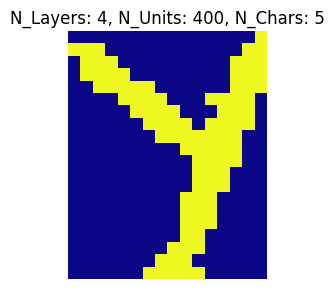

In [80]:
# Exemple d'utilisation avec des configurations générées
configurations = generate_symmetric_configurations(min_layers = 4, max_layers = 4, min_neurons = 400, max_neurons = 400, step_neurons = 100)
run_experiment(configurations, n_epochs=1000, characters=['Y', 'A', 'B', '1', '2'])



# read saved files for RBM and DBM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def load_and_display_image(file_path):
    """
    Charge et affiche une image à partir d'un fichier .npy.
    
    Args:
    file_path (str): Le chemin du fichier .npy à charger.
    """
    # Charger l'image à partir du fichier .npy
    image = np.load(file_path)
    
    image_data_reshaped = image.reshape((20, 16))

    # Afficher l'image
    plt.imshow(image_data_reshaped, cmap='plasma') # ou 'gray ou 'viridis' ou 'inferno' ou 'plasma' ou 'magma' ou 'cividis')
    plt.title("Loaded Image")
    plt.axis('off')  # Désactiver les axes pour une meilleure visualisation
    plt.show()

# Exemple d'utilisation
file_path = "../resultat/dbn/100_Units_2_Layers/Units_100_Chars_A.npy"
load_and_display_image(file_path)

file_path2 = "../resultat/rbn/100_Units_2_Chars.npy"
load_and_display_image(file_path2)